In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# 1. Data
## 1.1 General Imports and reading the Dataset

In [2]:
dataset_path = "D:\\FPT\\Capstone Project\\IDS-using-machine-learning\\SLIPS\\MachineLearningCVE"

In [3]:
if os.path.isdir(dataset_path):
    # Load from directory (multiple CSV files)
    df = pd.DataFrame()
    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(dirname, filename)
                print(f"Reading file: {file_path}")
                df = pd.concat([df, pd.read_csv(file_path)], ignore_index=True)
else:
    # Load from single CSV file
    df = pd.read_csv(dataset_path)

Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-using-machine-learning\SLIPS\MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
Reading file: D:\FPT\Capstone Project\IDS-

In [4]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# 2. Exploratory Data Analysis
The column names have leading and/or trailing spaces that need to be trimmed.

The info shows us the number of entries $n$ in the dataset aswell as the 79 columns with 0-77 being the features and 78 being the labels. 
When using the whole dataset the number of non-null entries are not displayed but we will address that later.
The feature types are all numerical and the lables are Objects (strings)

In [5]:
df.columns = df.columns.str.strip()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# 3. Preprocessing
The dataset is not fully cleaned up.
### Problems: 
- Infinite and -infinite values
- NaN values
- Duplicate values
- Missing values

None of these values make sense in the context of network flows. That is why we are going to delete all of them before continuing.

In [11]:
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [6]:
df.shape

(2830743, 79)

In [7]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [8]:
# Convert labels to binary (benign=0, attack=1) if 'Label' exists
if 'Label' in df.columns:
    df['Label'] = np.where((df['Label'] == 'BENIGN') | (df['Label'] == 'benign'), 0, 1)
elif 'label' in df.columns:
    df['Label'] = np.where((df['label'] == 'BENIGN') | (df['label'] == 'benign'), 0, 1)
    df.drop('label', axis=1, inplace=True)
    
# First verify the original distribution
if 'Label' in df.columns:
    orig_labels = df['Label']

In [9]:
unique, counts = np.unique(df['Label'], return_counts=True)
label_counts = dict(zip(unique, counts))
print(f"LABEL DISTRIBUTION: {label_counts}")

# Calculate the ratio between classes
if 0 in label_counts and 1 in label_counts:
    ratio = label_counts[0] / label_counts[1]
print(f"Ratio: {ratio}")

LABEL DISTRIBUTION: {0: 2273097, 1: 557646}
Ratio: 4.076236537157982


In [10]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
# Log missing values and filling it with median value
if df.isna().sum().sum() > 0:
    print(f"Missing values before imputation: {df.isna().sum().sum()}")
    
    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['float', 'int']).columns
    for col in numeric_cols:
        if df[col].isna().sum() > 0:
            print(f"Filling missing values in {col} with median")
            df[col] = df[col].fillna(df[col].median())

Missing values before imputation: 5734
Filling missing values in Flow Bytes/s with median
Filling missing values in Flow Packets/s with median


In [12]:
# Drop rows that still have NaN values
df.dropna(inplace=True)

# Drop duplicates
n_duplicates = df.duplicated().sum()
if n_duplicates > 0:
    print(f"Removing {n_duplicates} duplicate rows")
    df.drop_duplicates(inplace=True)

Removing 308381 duplicate rows


In [13]:
unique, counts = np.unique(df['Label'], return_counts=True)
label_counts = dict(zip(unique, counts))
print(f"LABEL DISTRIBUTION: {label_counts}")

# Calculate the ratio between classes
if 0 in label_counts and 1 in label_counts:
    ratio = label_counts[0] / label_counts[1]
print(f"Ratio: {ratio}")

LABEL DISTRIBUTION: {0: 2096484, 1: 425878}
Ratio: 4.922733740648731


In [14]:
# Count initial class distribution
class_counts = df['Label'].value_counts()
print(f"Initial class distribution: {class_counts.to_dict()}")

Initial class distribution: {0: 2096484, 1: 425878}


In [15]:
# Separate benign and attack instances
benign = df[df['Label'] == 0]
attacks = df[df['Label'] != 0]
print(f"Benign samples: {len(benign)}, Attack samples: {len(attacks)}")

Benign samples: 2096484, Attack samples: 425878


In [16]:
# Determine target sample size - default to size of minority class
# But allow specifying a different balance strategy if needed
sample_size = min(len(benign), len(attacks))
print(f"Target sample size per class: {sample_size}")

Target sample size per class: 425878


In [17]:
# Sample both classes to ensure exact balance
if len(benign) > sample_size:
    benign_sampled = benign.sample(n=sample_size, random_state=42)
else:
    benign_sampled = benign
    
if len(attacks) > sample_size:
    attacks_sampled = attacks.sample(n=sample_size, random_state=42)
else:
    attacks_sampled = attacks

In [18]:
# Combine and shuffle
balanced_df = pd.concat([benign_sampled, attacks_sampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Log final balance check
final_counts = balanced_df['Label'].value_counts()
print(f"Final class distribution: {final_counts.to_dict()}")

Final class distribution: {0: 425878, 1: 425878}


### Prepare features and target for model training.

In [19]:
# Map CICIDS2017 column names to Suricata feature names
feature_mapping = {
    'Destination Port': 'dest_port',
    'Flow Duration': 'duration',
    'Total Fwd Packets': 'total_fwd_packets',
    'Total Backward Packets': 'total_bwd_packets',
    'Total Length of Fwd Packets': 'total_fwd_bytes',
    'Total Length of Bwd Packets': 'total_bwd_bytes',
    'Flow Bytes/s': 'flow_bytes_per_sec',
    'Flow Packets/s': 'flow_packets_per_sec',
    'Down/Up Ratio': 'down_up_ratio'
}

# Extract target
y = balanced_df['Label'].values

In [20]:
# Select only the mapped features
features_to_use = []
for cicids_col, suricata_col in feature_mapping.items():
    if cicids_col in balanced_df.columns:
        features_to_use.append(cicids_col)

X = balanced_df[features_to_use].copy()

In [21]:
# Rename columns to match Suricata feature names
X.columns = [feature_mapping[col] for col in X.columns]

### TRAINING MODEL

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique, counts))
print(f"LABEL DISTRIBUTION: {label_counts}")

LABEL DISTRIBUTION: {0: 319408, 1: 319409}


In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Create label encoder for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

## Decision Tree

Training time: 6.13 seconds
Prediction time: 0.03 seconds
{'0': {'precision': 0.9922184839200797, 'recall': 0.9916220531605147, 'f1-score': 0.9919201788834815, 'support': 106470.0}, '1': {'precision': 0.9916270075938911, 'recall': 0.992223088410711, 'f1-score': 0.9919249584510944, 'support': 106469.0}, 'accuracy': 0.9919225693743279, 'macro avg': {'precision': 0.9919227457569855, 'recall': 0.9919225707856129, 'f1-score': 0.9919225686672879, 'support': 212939.0}, 'weighted avg': {'precision': 0.9919227471458252, 'recall': 0.9919225693743279, 'f1-score': 0.9919225686560651, 'support': 212939.0}}
Decision Tree Accuracy: 0.9919
Decision Tree F1 Score: 0.9919
Decision Tree evaluation:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    106470
           1       0.99      0.99      0.99    106469

    accuracy                           0.99    212939
   macro avg       0.99      0.99      0.99    212939
weighted avg       0.99      0.99     

Text(95.72222222222221, 0.5, 'True Label')

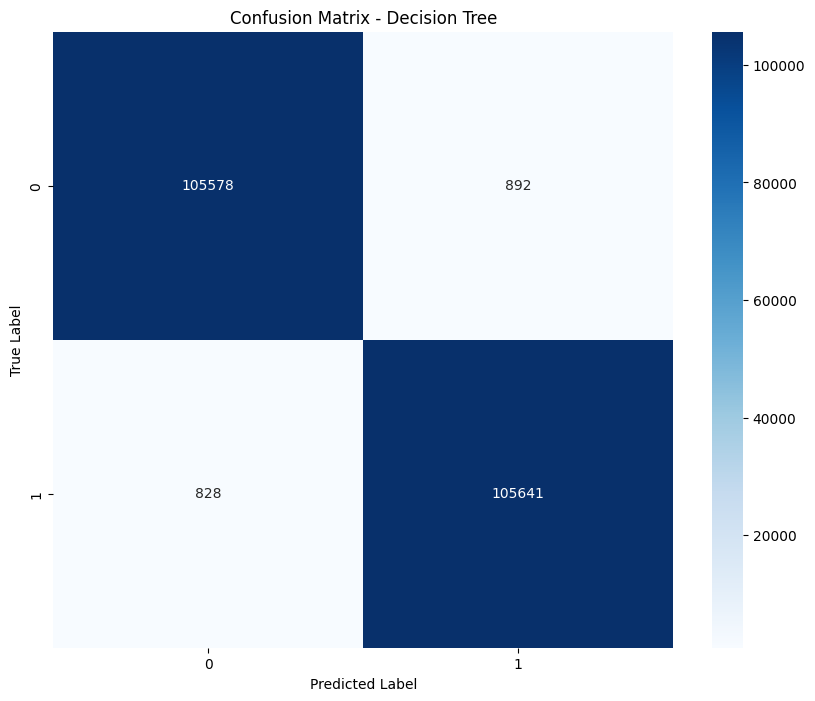

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


start_fit = time.time()
dt = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
dt.fit(X_train_scaled_df, y_train)
end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")
rf_fit_t = end_fit - start_fit

# Evaluate model
start_pred = time.time()
y_pred = dt.predict(X_test_scaled_df)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

name = "Decision Tree"
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
print(report)
# Log results
print(f"{name} Accuracy: {accuracy:.4f}")
print(f"{name} F1 Score: {report['weighted avg']['f1-score']:.4f}")

print("Decision Tree evaluation:")
print("\n" + classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


## Random Forest

Training time: 177.28 seconds
Prediction time: 2.26 seconds
{'0': {'precision': 0.9936529993333771, 'recall': 0.9939983093829248, 'f1-score': 0.9938256243631941, 'support': 106470.0}, '1': {'precision': 0.9939961665664462, 'recall': 0.9936507340164743, 'f1-score': 0.9938234202751514, 'support': 106469.0}, 'accuracy': 0.9938245225158379, 'macro avg': {'precision': 0.9938245829499117, 'recall': 0.9938245216996995, 'f1-score': 0.9938245223191727, 'support': 212939.0}, 'weighted avg': {'precision': 0.993824582144124, 'recall': 0.9938245225158379, 'f1-score': 0.9938245223243481, 'support': 212939.0}}
Random Forest Accuracy: 0.9938
Random Forest F1 Score: 0.9938
Random Forest evaluation:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    106470
           1       0.99      0.99      0.99    106469

    accuracy                           0.99    212939
   macro avg       0.99      0.99      0.99    212939
weighted avg       0.99      0.99   

Text(95.72222222222221, 0.5, 'True Label')

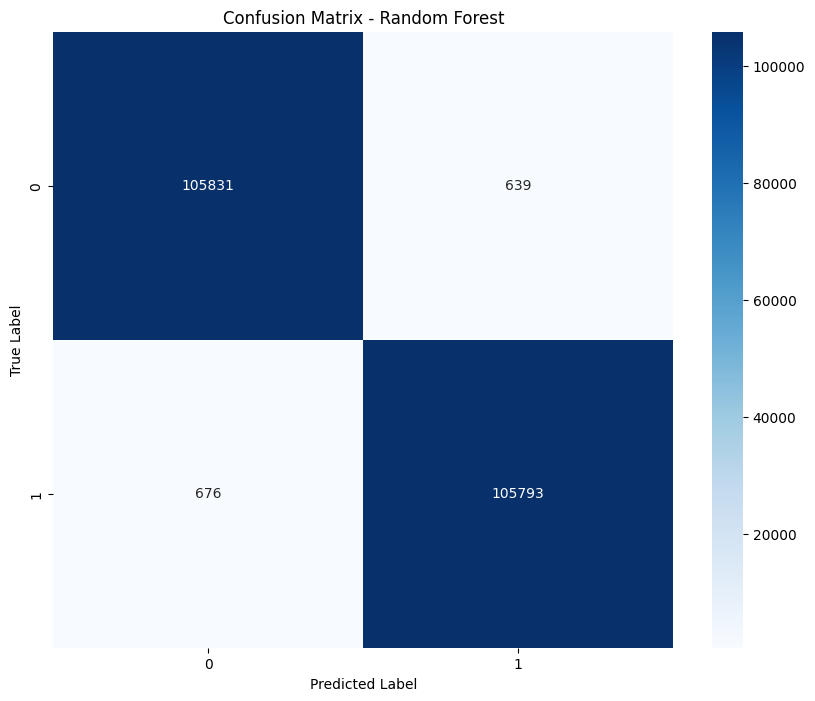

In [26]:
start_fit = time.time()
rf = RandomForestClassifier(
            n_estimators=100, 
            # max_depth=15,
            # min_samples_split=10,
            # min_samples_leaf=4,
            # max_features='sqrt',
            random_state=42,
            class_weight='balanced'
        )

rf.fit(X_train, y_train)
end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")

# Evaluate model
start_pred = time.time()
y_pred = rf.predict(X_test)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

name = "Random Forest"
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
print(report)
# Log results
print(f"{name} Accuracy: {accuracy:.4f}")
print(f"{name} F1 Score: {report['weighted avg']['f1-score']:.4f}")


print("Random Forest evaluation:")
print("\n" + classification_report(y_test, y_pred))



# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## Train an XGBoost classifier.

XGBoost basic model evaluation:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    106470
           1       0.98      1.00      0.99    106469

    accuracy                           0.99    212939
   macro avg       0.99      0.99      0.99    212939
weighted avg       0.99      0.99      0.99    212939

Performing hyperparameter tuning for XGBoost...


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages

Training time: 123.08 seconds
Best XGBoost parameters: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 100}
Prediction time: 0.17 seconds
{'0': {'precision': 0.9921779356104855, 'recall': 0.9971635202404433, 'f1-score': 0.9946644806183393, 'support': 106470.0}, '1': {'precision': 0.9971491683501048, 'recall': 0.9921385567630014, 'f1-score': 0.9946375522002985, 'support': 106469.0}, 'accuracy': 0.9946510503007904, 'macro avg': {'precision': 0.9946635519802951, 'recall': 0.9946510385017224, 'f1-score': 0.994651016409319, 'support': 212939.0}, 'weighted avg': {'precision': 0.9946635403073917, 'recall': 0.9946510503007904, 'f1-score': 0.9946510164725493, 'support': 212939.0}}
XGBoost Accuracy: 0.9947
XGBoost F1 Score: 0.9947
XGBoost tuned model evaluation:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    106470
           1       1.00      0.99      0.99    106469

    accuracy                           0.99    212939
   macro a

Text(95.72222222222221, 0.5, 'True Label')

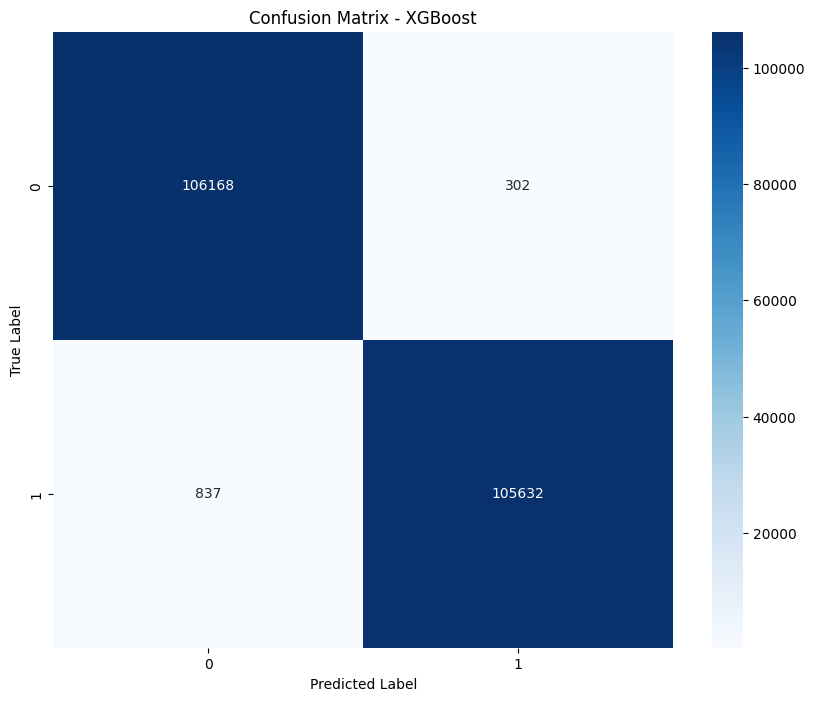

In [27]:
start_fit = time.time()
# Basic XGBoost model first
xgb = XGBClassifier(n_estimators=50, random_state=42, scale_pos_weight=5)
xgb.fit(X_train_scaled_df, y_train_encoded)


# Evaluate basic model
y_pred = xgb.predict(X_test_scaled_df)
y_test_decoded = le.inverse_transform(y_test_encoded)
y_pred_decoded = le.inverse_transform(y_pred)

print("XGBoost basic model evaluation:")
print("\n" + classification_report(y_test_decoded, y_pred_decoded))

# Hyperparameter tuning
print("Performing hyperparameter tuning for XGBoost...")
param_grid = {
            'max_depth': [6, 9, 12],
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1, 0.2]
        }
        
# Use GridSearchCV with reduced CV to save time
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # Reduced CV for faster training
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train_scaled_df, y_train_encoded)
end_fit = time.time()
print(f"Training time: {end_fit - start_fit:.2f} seconds")

print(f"Best XGBoost parameters: {grid_search.best_params_}")

# Get best model
xgb_best = grid_search.best_estimator_

# Evaluate best model
start_pred = time.time()
y_pred = xgb_best.predict(X_test_scaled_df)
end_pred = time.time()
print(f"Prediction time: {end_pred - start_pred:.2f} seconds")

y_pred_decoded = le.inverse_transform(y_pred)

name = "XGBoost"
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, output_dict=True)
print(report)
# Log results
print(f"{name} Accuracy: {accuracy:.4f}")
print(f"{name} F1 Score: {report['weighted avg']['f1-score']:.4f}")


print("XGBoost tuned model evaluation:")
print("\n" + classification_report(y_test_decoded, y_pred_decoded))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## Selected Features

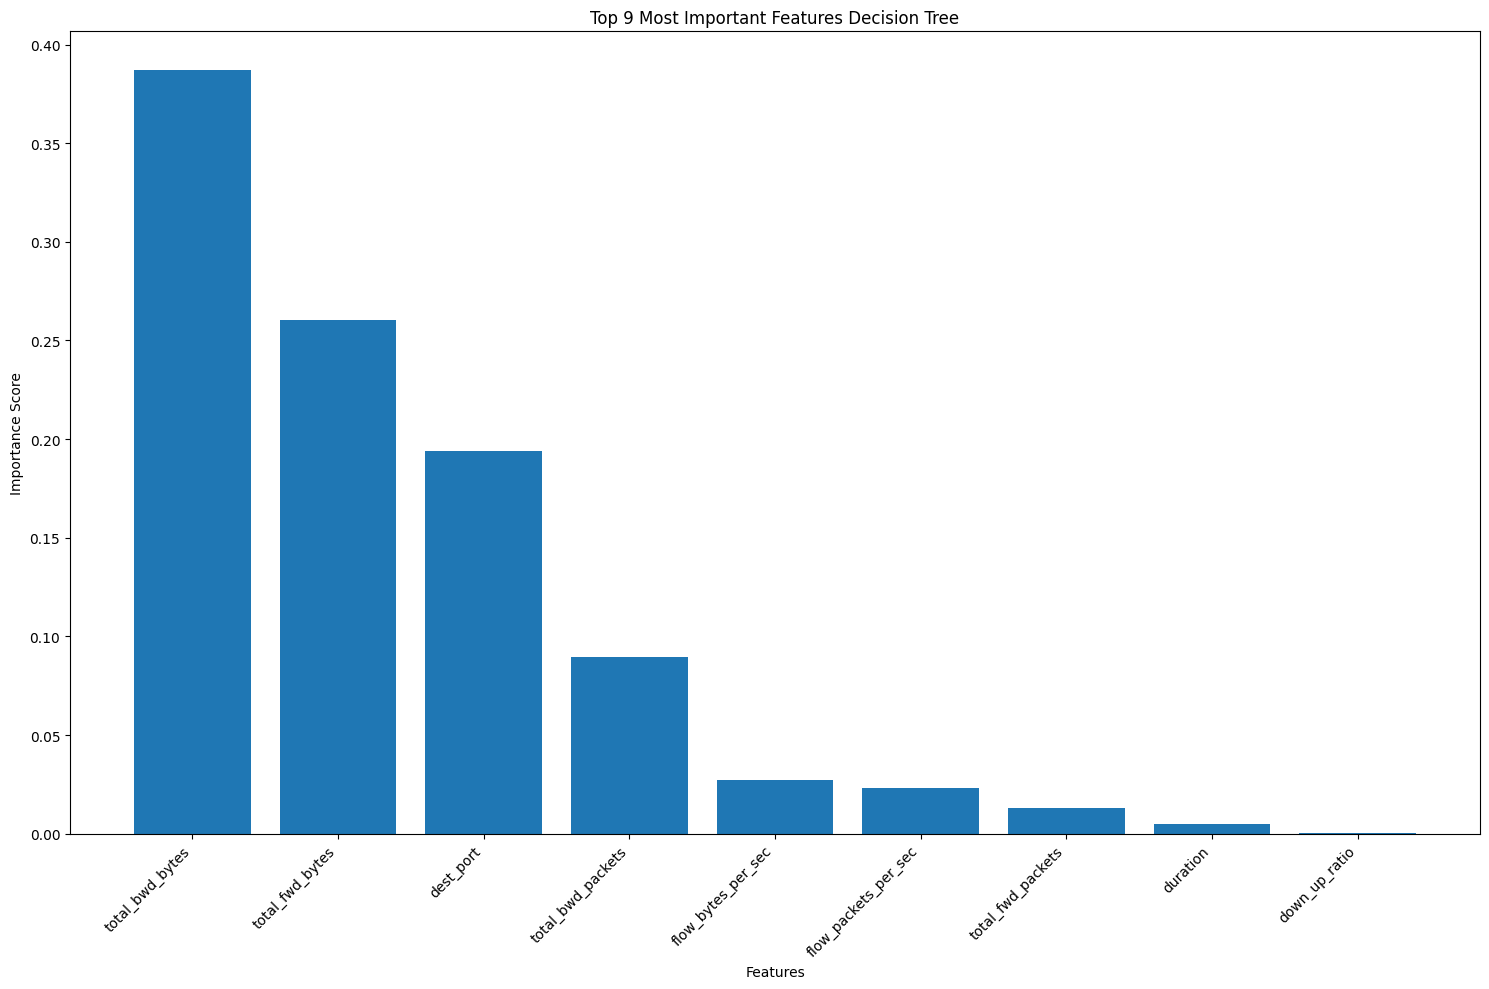


Top 9 Most Important Features Decision Tree:
             feature  importance
     total_bwd_bytes    0.387347
     total_fwd_bytes    0.260221
           dest_port    0.194012
   total_bwd_packets    0.089484
  flow_bytes_per_sec    0.027219
flow_packets_per_sec    0.023190
   total_fwd_packets    0.013101
            duration    0.004909
       down_up_ratio    0.000517


In [62]:
importances = dt.feature_importances_
feature_names = X.columns

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

num_of_features = len(importances)

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features Decision Tree')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features Decision Tree:")
print(feature_importance.to_string(index=False))

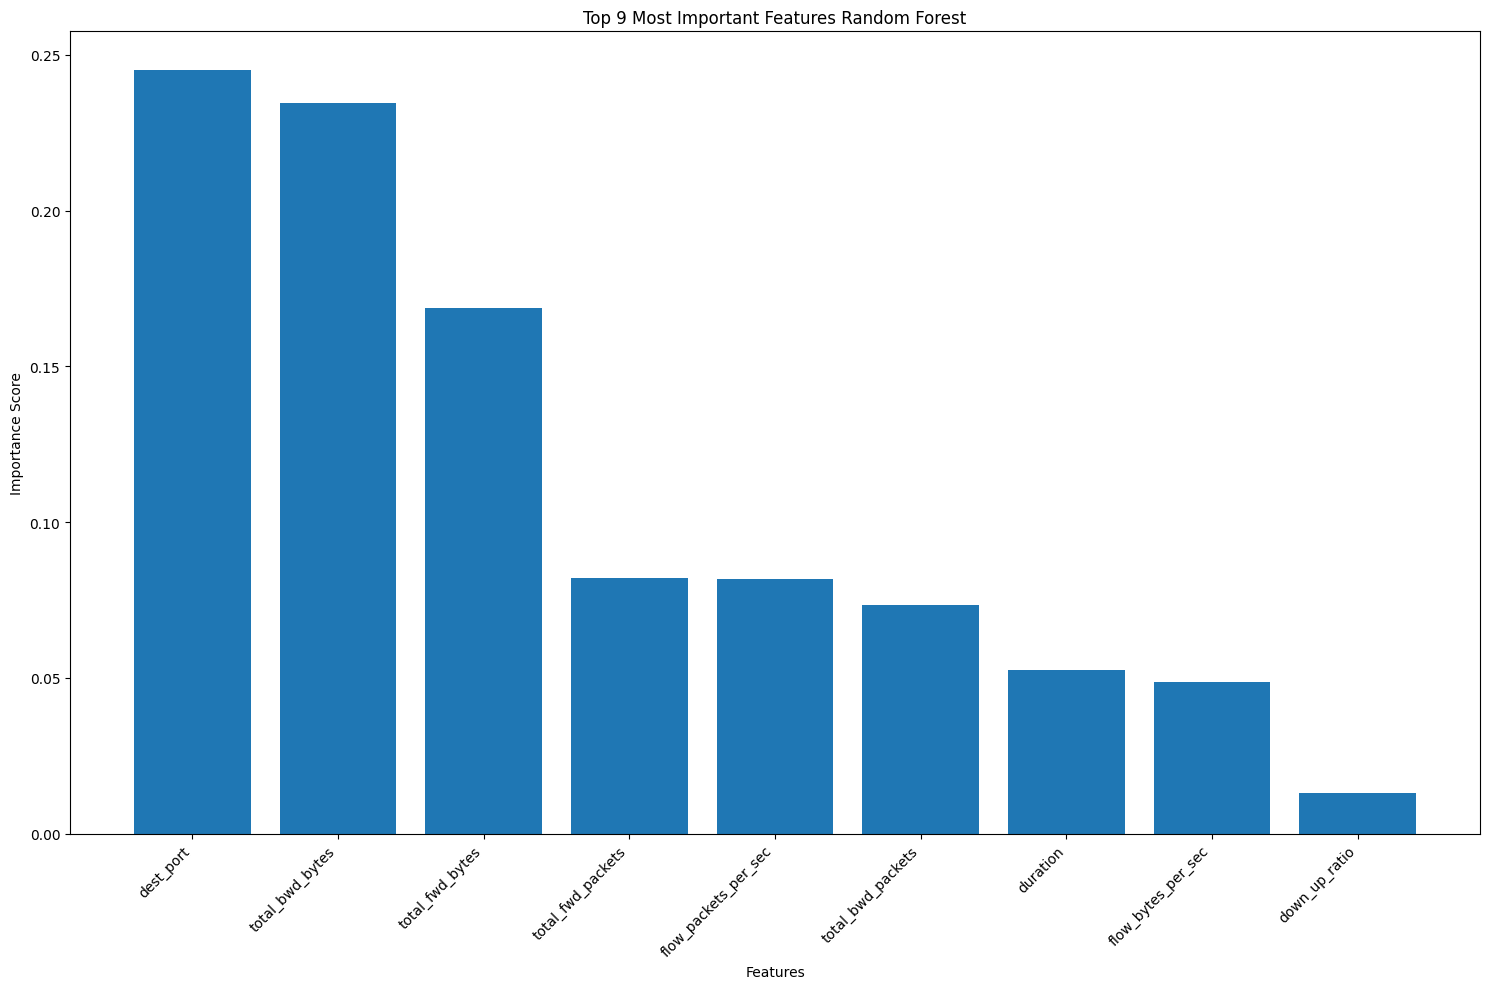


Top 9 Most Important Features Random Forest:
             feature  importance
           dest_port    0.245254
     total_bwd_bytes    0.234585
     total_fwd_bytes    0.168624
   total_fwd_packets    0.082066
flow_packets_per_sec    0.081891
   total_bwd_packets    0.073381
            duration    0.052678
  flow_bytes_per_sec    0.048564
       down_up_ratio    0.012957


In [61]:
importances = rf.feature_importances_
feature_names = X.columns

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

num_of_features = len(importances)

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features Random Forest')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features Random Forest:")
print(feature_importance.to_string(index=False))

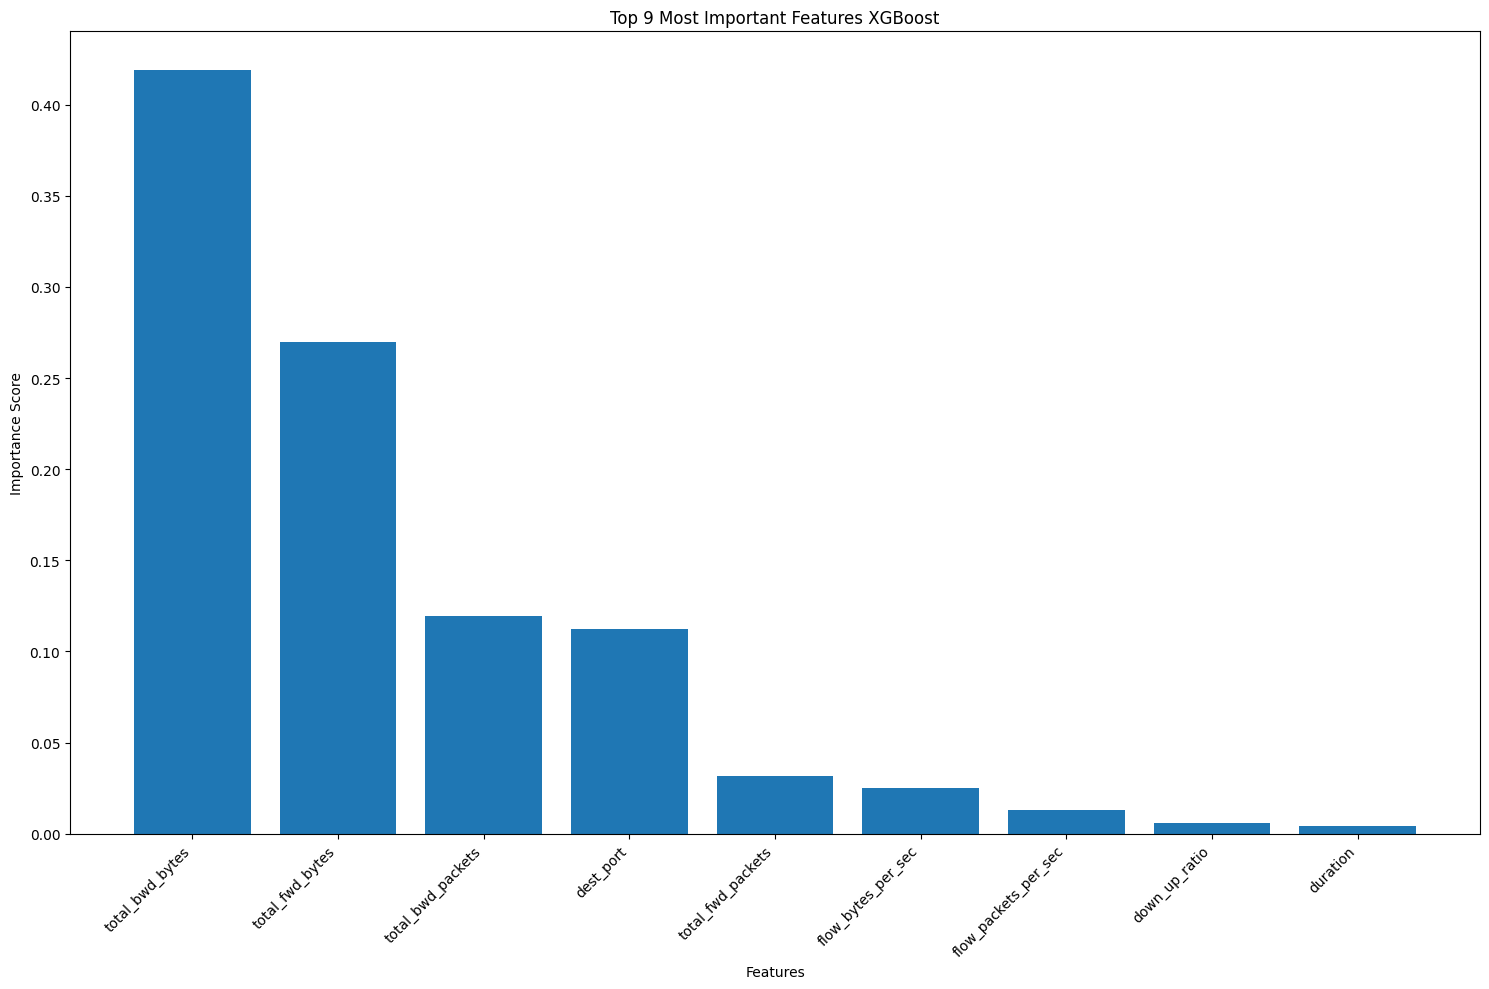


Top 9 Most Important Features XGBoost:
             feature  importance
     total_bwd_bytes    0.419334
     total_fwd_bytes    0.270085
   total_bwd_packets    0.119229
           dest_port    0.112365
   total_fwd_packets    0.031438
  flow_bytes_per_sec    0.024794
flow_packets_per_sec    0.012734
       down_up_ratio    0.006081
            duration    0.003939


In [60]:
importances = xgb_best.feature_importances_
feature_names = X.columns

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

num_of_features = len(importances)

# contruct feature importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features XGBoost')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features XGBoost:")
print(feature_importance.to_string(index=False))